## Plotting Results -- Global vs Europe

In [1]:
import pickle
import random

random.seed(1234)

model_europe = ['model_7', 'model_10', 'model_6', 'model_5', 'model_4']

model_globe = ['model_8', 'model_9', 'model_11', 'model_12', 'model_13']

loss_eur = []
mae_eur = []
r2_eur = []
loss_eur_test = []
mae_eur_test = []
r2_eur_test = []
for i in model_europe:
    with open('../results/'+ i +'/model-history.pkl', 'rb') as f:
        data = pickle.load(f)
        loss_eur.append(data['model']['train'][199]['loss'])
        mae_eur.append(data['model']['train'][199]['MAE'])
        r2_eur.append(data['model']['train'][199]['r2_coef'])
        loss_eur_test.append(data['model']['test'][199]['loss'])
        mae_eur_test.append(data['model']['test'][199]['MAE'])
        r2_eur_test.append(data['model']['test'][199]['r2_coef'])

loss_glob = []
mae_glob = []
r2_glob = []
loss_glob_test = []
mae_glob_test = []
r2_glob_test = []
for i in model_globe:
    with open('../results/'+ i +'/model-history.pkl', 'rb') as f:
        data = pickle.load(f)
        loss_glob.append(data['model']['train'][199]['loss'])
        mae_glob.append(data['model']['train'][199]['MAE'])
        r2_glob.append(data['model']['train'][199]['r2_coef'])
        loss_glob_test.append(data['model']['test'][199]['loss'])
        mae_glob_test.append(data['model']['test'][199]['MAE'])
        r2_glob_test.append(data['model']['test'][199]['r2_coef'])

## Loss - Global vs Europe

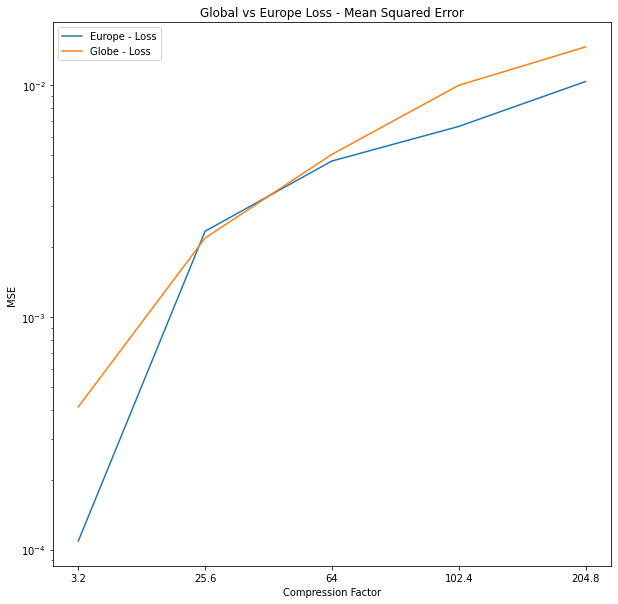

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,loss_eur , label = "Europe - Loss")
plt.plot(x,loss_glob , label = "Globe - Loss")
plt.yscale('log')
plt.title('Global vs Europe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

## R2 - Global vs Europe

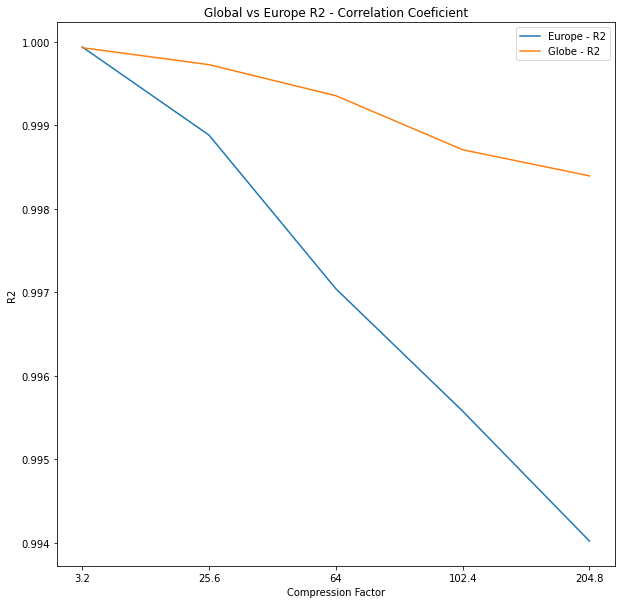

In [3]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,r2_eur , label = "Europe - R2")
plt.plot(x,r2_glob , label = "Globe - R2")
#plt.yscale('log')
plt.title('Global vs Europe R2 - Correlation Coeficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

## MAE - Global vs Europe

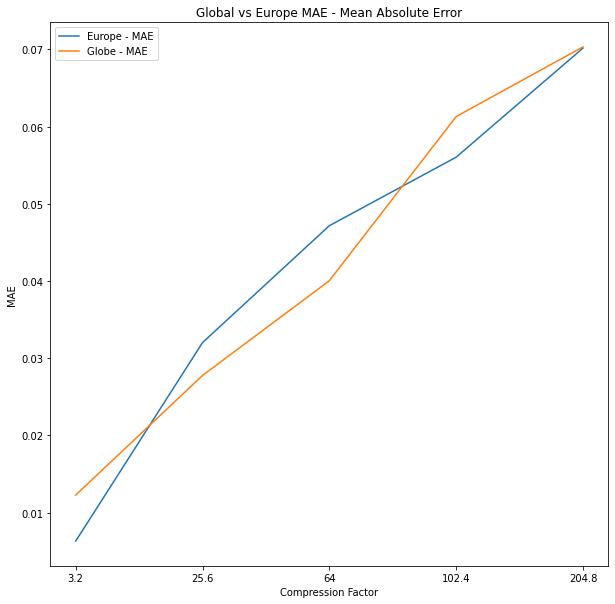

In [4]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , label = "Europe - MAE")
plt.plot(x,mae_glob , label = "Globe - MAE")
#plt.yscale('log')
plt.title('Global vs Europe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Evaluating Loss, R2, MAE - 1979 vs 1980 only in Europe

In [5]:
import xarray as xr
import tensorflow as tf
from collections import OrderedDict
from lossycomp.models import Autoencoder
from tensorflow.keras.optimizers import Adam
from lossycomp.plots import mult_plot, single_plot, plot_history
from lossycomp.utils import check_gpu, decay_schedule, r2_coef
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=40, latitude=40, level=1)

model_name = 'model_7'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

dg_val_europe = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


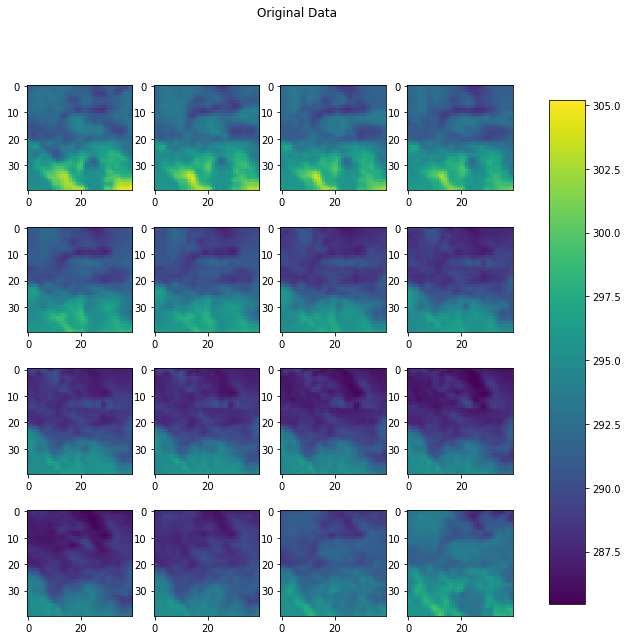

In [14]:
from lossycomp.plots import mult_plot, single_plot, plot_history
import numpy as np
test_n = norm_data(dg_val_europe.__getitem__(0)[0][1], mean, std)
test_n = np.expand_dims(test_n, axis=0)
mult_plot(test_n, 4, 4, "Original Data", test_n.min(), test_n.max())

In [8]:
print(dg_val_europe.__getitem__(90)[0][1].shape)
print(dg_val_europe.info(90)[1])

(16, 40, 40, 1)
{'longitude': slice(95, 135, None), 'latitude': slice(59, 99, None), 'level': slice(0, 1, None), 'time': slice(5270, 5286, None)}


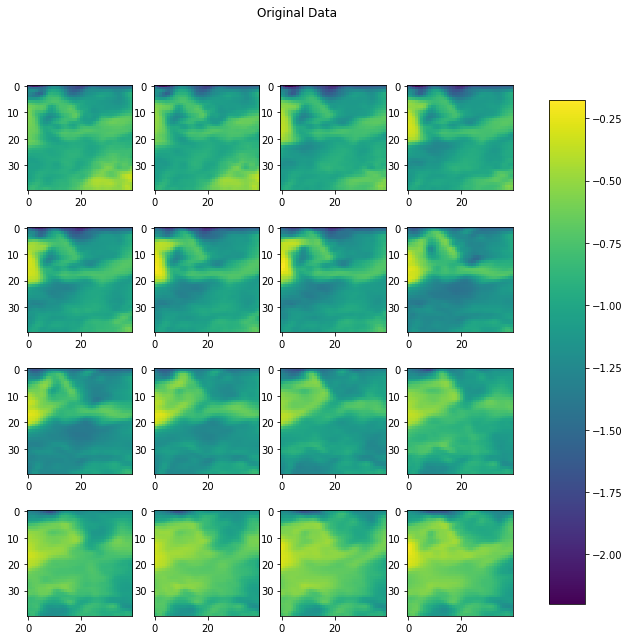

In [7]:
aa = dg_val_europe.data.isel(longitude= slice(95, 135),
 latitude =  slice(59, 99),
 level=  slice(0,1),
 time =slice(5270, 5286))

test_data = np.expand_dims(aa, axis=0)

mult_plot(test_data, 4, 4, "Original Data", test_data.min(), test_data.max())

In [6]:
# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe)

1000/1000 [==============================] - 39s 39ms/step - loss: 1.0026e-04 - r2_coef: 0.9999 - MAE: 0.0061


In [7]:
res

[0.00010025893425336108, 0.999938428401947, 0.00609591044485569]

In [8]:
model_name = 'model_10'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe)

1000/1000 [==============================] - 39s 39ms/step - loss: 0.0021 - r2_coef: 0.9987 - MAE: 0.0303


In [9]:
res

[0.002119653392583132, 0.9986813068389893, 0.03029491938650608]

In [10]:
model_name = 'model_6'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (32, 16, 8))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe)

1000/1000 [==============================] - 38s 38ms/step - loss: 0.0046 - r2_coef: 0.9972 - MAE: 0.0450


In [11]:
res

[0.004556597676128149, 0.9971935749053955, 0.04502406716346741]

In [12]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_val_europe_48 = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [13]:
model_name = 'model_5'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 40], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe_48)

1000/1000 [==============================] - 44s 44ms/step - loss: 0.0062 - r2_coef: 0.9961 - MAE: 0.0537


In [14]:
res

[0.006232471205294132, 0.9960570931434631, 0.05367785319685936]

In [15]:
model_name = 'model_4'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 20], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe_48)

1000/1000 [==============================] - 46s 46ms/step - loss: 0.0097 - r2_coef: 0.9939 - MAE: 0.0678


In [16]:
res

[0.009723539464175701, 0.9938862323760986, 0.0678497850894928]

In [17]:
losses_eur_val = [0.00010036735329777002, 0.0021272955927997828, 0.004528641235083342, 0.006245248019695282, 0.009771274402737617]
r2s_eur_val = [0.9999386072158813, 0.998690128326416, 0.997221827507019, 0.9960830211639404, 0.993820309638977]
maes_eur_val = [0.006093519274145365, 0.030291225761175156, 0.04488058015704155, 0.05375417694449425, 0.06801731139421463]

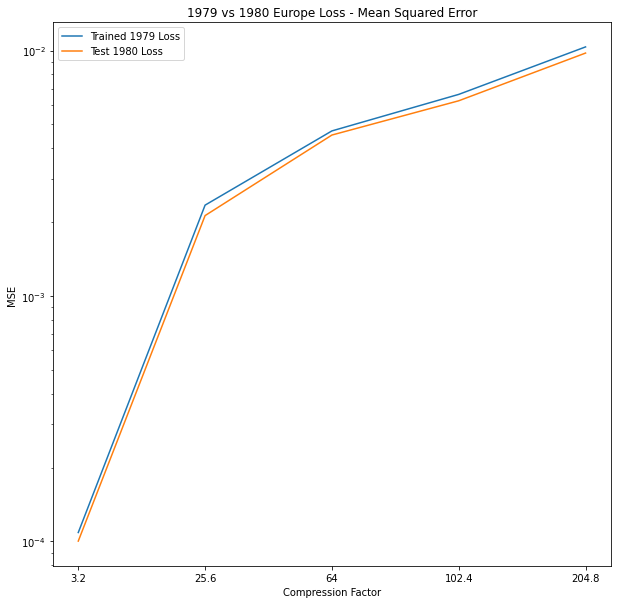

In [18]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, loss_eur, label = "Trained 1979 Loss")
plt.plot(x, losses_eur_val , label = "Test 1980 Loss")
plt.yscale('log')
plt.title('1979 vs 1980 Europe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

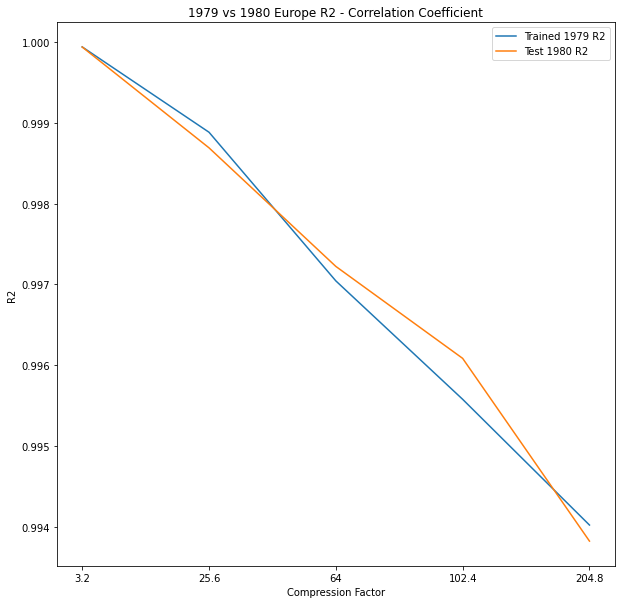

In [19]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2_eur, label = "Trained 1979 R2")
plt.plot(x, r2s_eur_val , label = "Test 1980 R2")
#plt.yscale('log')
plt.title('1979 vs 1980 Europe R2 - Correlation Coefficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

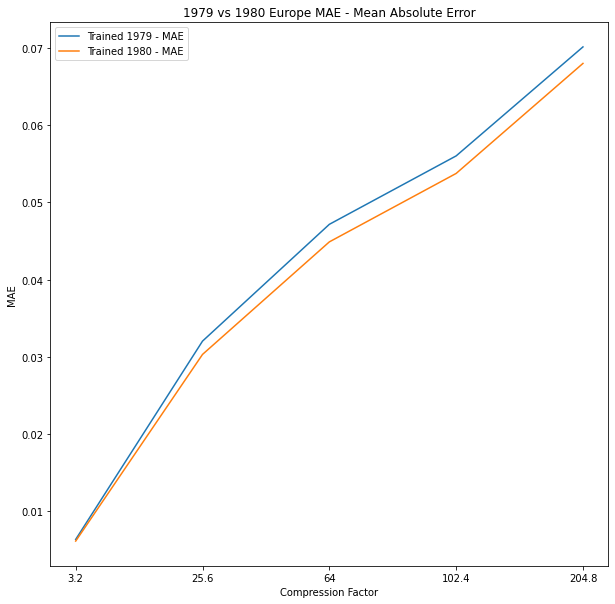

In [20]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , label = "Trained 1979 - MAE")
plt.plot(x, maes_eur_val , label = "Trained 1980 - MAE")
plt.title('1979 vs 1980 Europe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Evaluating Loss, R2, MAE - 1979 vs 1980 only in Global

In [21]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "globe"
var = OrderedDict({'t': 1000})

import dask

dask.config.set(**{'array.slicing.split_large_chunks': False})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=40, latitude=40, level=1)

dg_val_globe = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [22]:
model_name = 'model_8'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.models import Autoencoder
# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 42s 42ms/step - loss: 7.5310e-04 - r2_coef: 0.9999 - MAE: 0.0175


In [23]:
res

[0.0007530951406806707, 0.999883770942688, 0.017474781721830368]

In [24]:
model_name = 'model_9'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 43s 43ms/step - loss: 0.0022 - r2_coef: 0.9997 - MAE: 0.0275


In [25]:
res

[0.002220194786787033, 0.9996722340583801, 0.027501925826072693]

In [26]:
model_name = 'model_11'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (32, 16, 8))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 43s 43ms/step - loss: 0.0046 - r2_coef: 0.9993 - MAE: 0.0399


In [27]:
res

[0.004556781146675348, 0.9993274807929993, 0.03988507017493248]

In [28]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "globe"
var = OrderedDict({'t': 1000})

import dask

dask.config.set(**{'array.slicing.split_large_chunks': False})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_val_globe_48 = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [29]:
model_name = 'model_12'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.models import Autoencoder
# Load model architecture.
(encoder, decoder, model)  = Autoencoder.build(16, 48, 48, 1, filters = (10, 20, 20,20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

1000/1000 [==============================] - 52s 52ms/step - loss: 0.0106 - r2_coef: 0.9986 - MAE: 0.0634


In [30]:
res

[0.010605428367853165, 0.9985687136650085, 0.06344160437583923]

In [31]:
model_name = 'model_13'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']
    
# Load model architecture.
(encoder, decoder, model) =  Autoencoder.build(16, 48, 48, 1, filters = (10,20,20,40))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

1000/1000 [==============================] - 48s 48ms/step - loss: 0.0112 - r2_coef: 0.9985 - MAE: 0.0649


In [32]:
res

[0.011248608119785786, 0.9984690546989441, 0.0649455115199089]

In [33]:
losses_glob_val = [0.0007514542667195201,0.0021963240578770638, 0.0045438953675329685, 0.010696414858102798, 0.011268912814557552]
r2s_glob_val = [ 0.9998841285705566, 0.9996765851974487, 0.9993316531181335, 0.9985462427139282,  0.9984663724899292]
maes_glob_val = [ 0.017514921724796295, 0.027353713288903236, 0.039901286363601685, 0.06357172131538391, 0.0650133118033409]

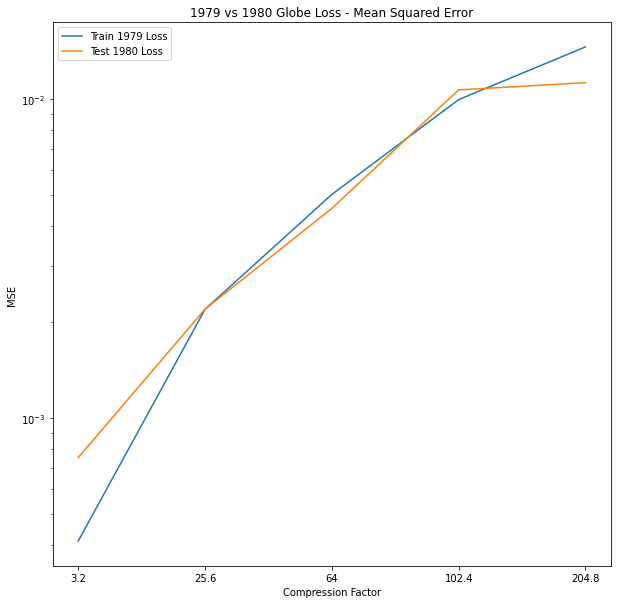

In [34]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, loss_glob, label = "Train 1979 Loss")
plt.plot(x, losses_glob_val , label = "Test 1980 Loss")
plt.yscale('log')
plt.title('1979 vs 1980 Globe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

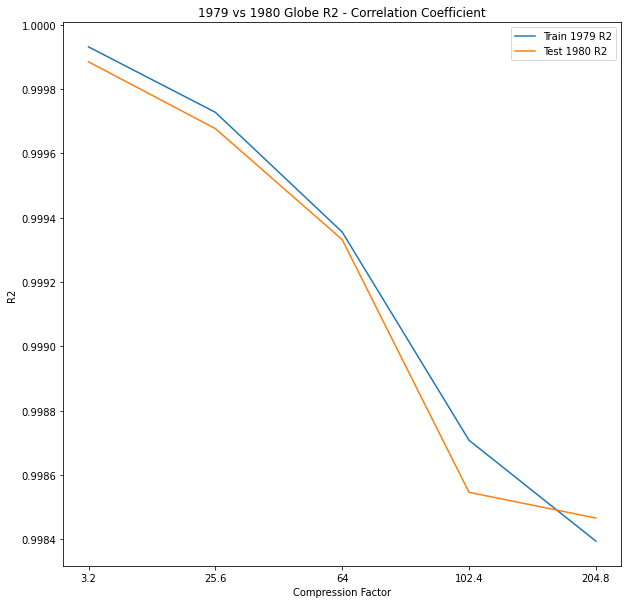

In [35]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2_glob, label = "Train 1979 R2")
plt.plot(x, r2s_glob_val , label = "Test 1980 R2")
plt.title('1979 vs 1980 Globe R2 - Correlation Coefficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

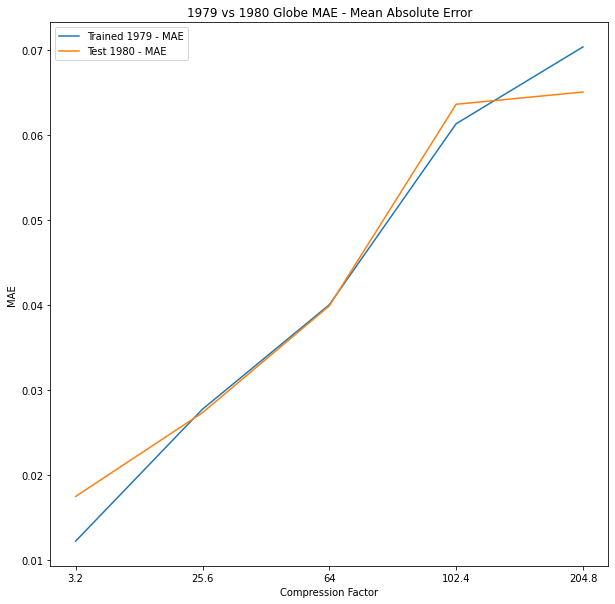

In [36]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_glob , label = "Trained 1979 - MAE")
plt.plot(x, maes_glob_val , label = "Test 1980 - MAE")
plt.title('1979 vs 1980 Globe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Trained in europe, tested over the globe.

In [37]:
model_name = 'model_7'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.models import Autoencoder
# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 47s 47ms/step - loss: 1.7066e-04 - r2_coef: 1.0000 - MAE: 0.0067


In [38]:
res

[0.0001706635084701702, 0.9999819397926331, 0.006709206849336624]

In [39]:
model_name = 'model_10'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 42s 42ms/step - loss: 0.0022 - r2_coef: 0.9997 - MAE: 0.0275


In [40]:
res

[0.0021568152587860823, 0.9996837377548218, 0.02746403217315674]

In [41]:
model_name = 'model_6'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (32, 16, 8))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 40s 40ms/step - loss: 0.0069 - r2_coef: 0.9990 - MAE: 0.0446


In [42]:
res

[0.006945624947547913, 0.9989863038063049, 0.04463711380958557]

In [43]:
model_name = 'model_5'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 40], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

1000/1000 [==============================] - 51s 51ms/step - loss: 0.0069 - r2_coef: 0.9991 - MAE: 0.0504


In [44]:
res

[0.0068815783597528934, 0.9990654587745667, 0.05040992796421051]

In [2]:
model_name = 'model_4'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 20], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

NameError: name 'pickle' is not defined

In [46]:
res

[0.010457174852490425, 0.9985857009887695, 0.06260299682617188]

In [47]:
losses_eur_glob_val = [0.00017146677419077605,0.0021514890249818563,0.006753660272806883, 0.006883593741804361,0.01061693113297224 ]
r2s_eur_glob_val = [0.9999818801879883,0.9996828436851501,0.9990004897117615,0.9990699291229248,0.9985544681549072]
maes_eur_glob_val = [0.006718733813613653,  0.0274074524641037, 0.04417809471487999, 0.05051010474562645, 0.06301198899745941]

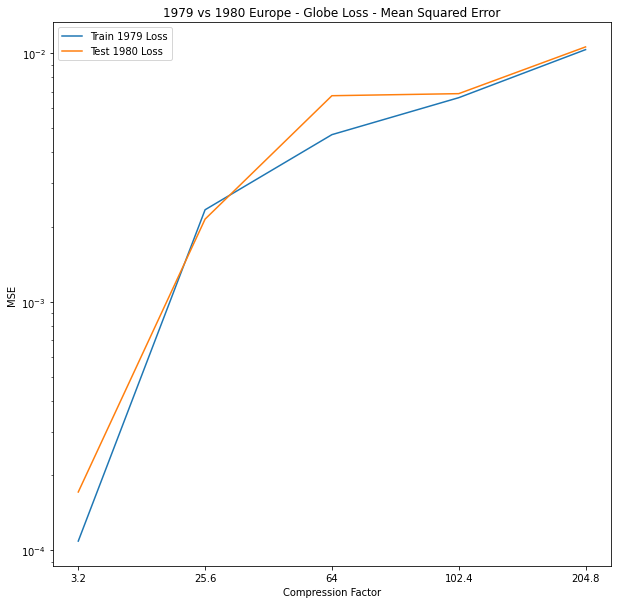

In [48]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, loss_eur, label = "Train 1979 Loss")
plt.plot(x, losses_eur_glob_val , label = "Test 1980 Loss")
plt.yscale('log')
plt.title('1979 vs 1980 Europe - Globe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

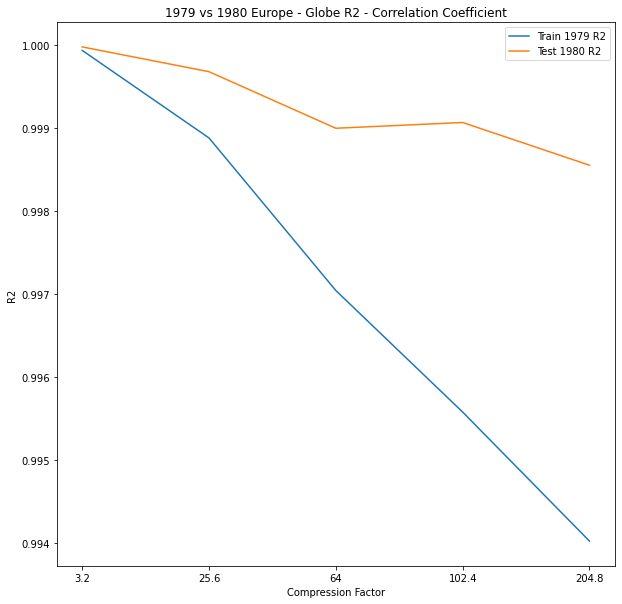

In [49]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2_eur, label = "Train 1979 R2")
plt.plot(x, r2s_eur_glob_val , label = "Test 1980 R2")
plt.title('1979 vs 1980 Europe - Globe R2 - Correlation Coefficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

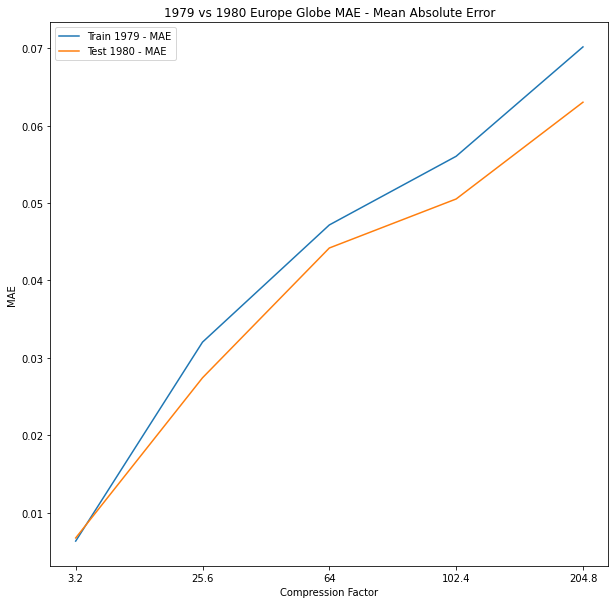

In [50]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , label = "Train 1979 - MAE")
plt.plot(x, maes_eur_glob_val , label = "Test 1980 - MAE")
plt.title('1979 vs 1980 Europe Globe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

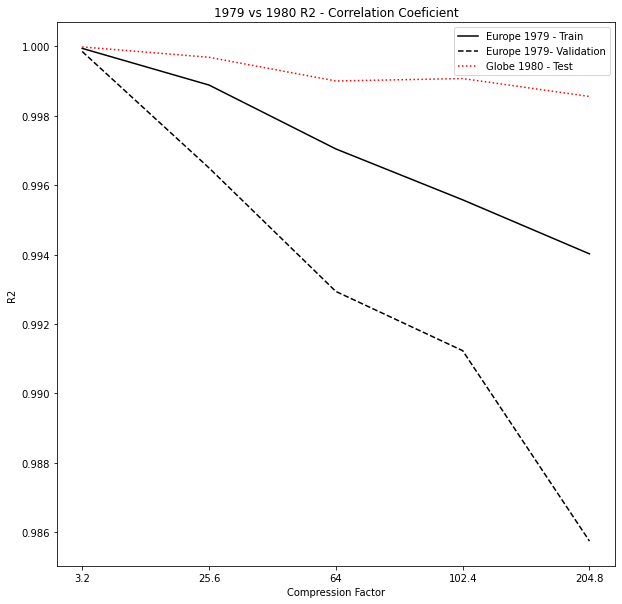

In [54]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,r2_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x, r2_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, r2s_eur_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, r2s_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
#plt.yscale('log')
plt.title('1979 vs 1980 R2 - Correlation Coeficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

## Plotting everything together

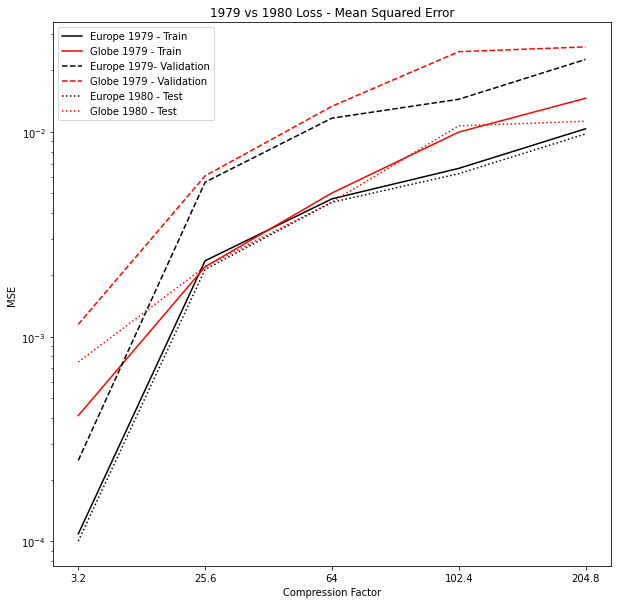

In [51]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,loss_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x,loss_glob , 'r-', label = "Globe 1979 - Train")
plt.plot(x, loss_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, loss_glob_test , 'r--',label = "Globe 1979 - Validation")
plt.plot(x, losses_eur_val , 'k:',label = "Europe 1980 - Test")
plt.plot(x, losses_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, losses_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
plt.yscale('log')
plt.title('1979 vs 1980 Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

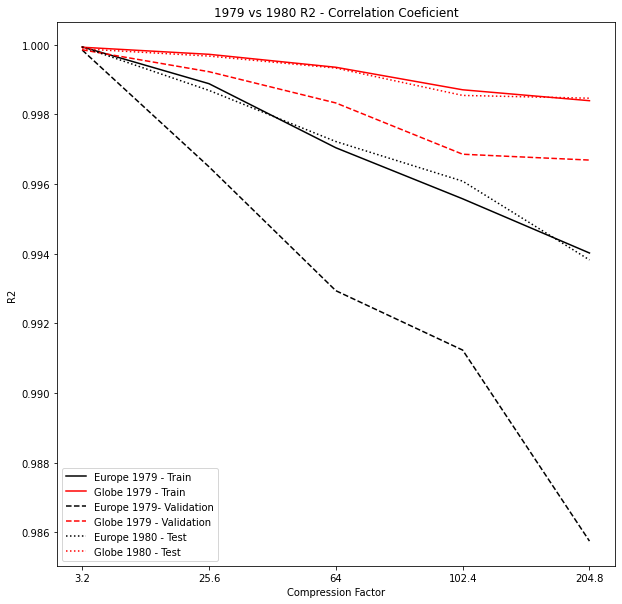

In [52]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,r2_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x,r2_glob , 'r-', label = "Globe 1979 - Train")
plt.plot(x, r2_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, r2_glob_test , 'r--',label = "Globe 1979 - Validation")
plt.plot(x, r2s_eur_val , 'k:',label = "Europe 1980 - Test")
plt.plot(x, r2s_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, r2s_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
#plt.yscale('log')
plt.title('1979 vs 1980 R2 - Correlation Coeficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

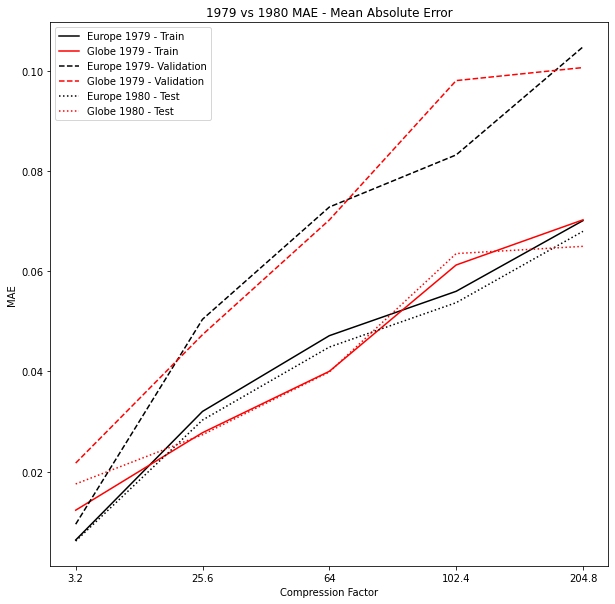

In [53]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x,mae_glob , 'r-', label = "Globe 1979 - Train")
plt.plot(x, mae_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, mae_glob_test , 'r--',label = "Globe 1979 - Validation")
plt.plot(x, maes_eur_val , 'k:',label = "Europe 1980 - Test")
plt.plot(x, maes_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, maes_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
#plt.yscale('log')
plt.title('1979 vs 1980 MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()